## __Importando bibliotecas necessárias__

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tfw
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import shutil
from sklearn.model_selection import KFold

## __Defina o caminho para as pastas__

In [3]:
pathO = os.getcwd()
path = pathO + "\\produtos_regionais\\"
path_load = pathO + "\\models\\"
pathKFold = pathO + "\\dataset\\train"
log_dir = pathO + "\\logs"
output_dir = pathO + "\\models\\"

## __Criar pasta de Logs__

In [4]:
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)  # Remove a pasta e todo o conteúdo
    print(f"Pasta existente removida: {log_dir}")

os.makedirs(log_dir)
print(f"Pasta criada: {log_dir}")

Pasta existente removida: C:\Users\PC\Documents\GitHub\treinandoEficcientNet2\logs
Pasta criada: C:\Users\PC\Documents\GitHub\treinandoEficcientNet2\logs


## __Criar o callback do TensorBoard__

In [5]:
tensorboard_callback = TensorBoard(log_dir=log_dir)

## __Configurações de Data Augmentation__

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

## __Informações do Dataset__

produtos_regionais/
│   ├── train/
│   │   ├── cupuacu/
│   │   │   ├── img1.jpg
│   │   │   ├── img2.jpg
│   │   │   └── ...
│   │   ├── manga/
│   │   │   ├── img1.jpg
│   │   │   ├── img2.jpg
│   │   │   └── ...
│   │   └── mandioca/
│   │   │   ├── img1.jpg
│   │   │   ├── img2.jpg
│   │   │   └── ...
│   │   └── mari/
│   │   │   ├── img1.jpg
│   │   │   ├── img2.jpg
│   │   │   └── ...
│   ├── val/
│   │   ├── cupuacu/
│   │   │   ├── img1.jpg
│   │   │   ├── img2.jpg
│   │   │   └── ...
│   │   ├── manga/
│   │   │   ├── img1.jpg
│   │   │   ├── img2.jpg
│   │   │   └── ...
│   │   └── mandioca/
│   │   │   ├── img1.jpg
│   │   │   ├── img2.jpg
│   │   │   └── ...
│   │   └── mari/
│   │   │   ├── img1.jpg
│   │   │   ├── img2.jpg
│   │   │   └── ...
│   │
│   └── test/
│       ├── cupuacu/
│   │   │   ├── img1.jpg
│   │   │   ├── img2.jpg
│   │   │   └── ...
│   │   ├── manga/
│   │   │   ├── img1.jpg
│   │   │   ├── img2.jpg
│   │   │   └── ...
│   │   └── mandioca/
│   │   │   ├── img1.jpg
│   │   │   ├── img2.jpg
│   │   │   └── ...
│   │   └── mari/
│   │   │   ├── img1.jpg
│   │   │   ├── img2.jpg
│   │   │   └── ...



link: https://drive.google.com/drive/folders/1lFRS7DnYjgDrd7rWx1m-EdHJttvwidny?usp=drive_link

## __Informações do Dispositivo__

Samsung SM-M526B

## __Gerando os dados de treino__

In [7]:
train_generator = datagen.flow_from_directory(
    directory=path + 'train',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
)

Found 272 images belonging to 4 classes.


## __Gerando os dados de validação__

In [8]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    directory=path + 'val',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 64 images belonging to 4 classes.


## __Gerando os dados de teste__

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Apenas normalização, sem augmentação

test_generator = test_datagen.flow_from_directory(
    directory=path + 'test',  # Substitua pelo caminho do diretório de teste
    target_size=(224, 224),          # Redimensiona as imagens para 224x224 pixels
    batch_size=32,                   # Tamanho do lote
    class_mode='categorical',
    shuffle=False
)

Found 124 images belonging to 4 classes.


## ___Listar classes e imagens___

In [10]:
classes = os.listdir(pathKFold)
filepaths = []
labels = []

for class_name in classes:
    class_dir = os.path.join(pathKFold, class_name)
    for fname in os.listdir(class_dir):
        filepaths.append(os.path.join(class_dir, fname))
        labels.append(class_name)

data = pd.DataFrame({'filepath': filepaths, 'label': labels})

## __Configurando o KFold__

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## __Definindo hiperparâmetros__

In [12]:
epochs = 20
batch_size = 32
learning_rate = 0.0001
optimizer = Adam
fold_no = 1

## __Treinando modelo com Kfold__

In [ ]:
results_Kfold = []
for train_index, val_index in kf.split(data):
    print(f"Treinando no Fold {fold_no}...")
    
    # Dados de treino e validação
    train_data = data.iloc[train_index]
    val_data = data.iloc[val_index]
    
    # Criando os generators
    tr_generator = datagen.flow_from_dataframe(
        train_data,
        x_col='filepath',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    val_generator = datagen.flow_from_dataframe(
        val_data,
        x_col='filepath',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    base_model = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    # Congelar as camadas iniciais para não treinar novamente
    for layer in base_model.layers[-100:]:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout com 50%
    x = Dense(128, activation='relu')(x)  # Camada densa com ReLU
    x = Dropout(0.5)(x)
    predictions = Dense(len(tr_generator.class_indices), 
                    activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compilando o modelo
    model.compile(optimizer=optimizer(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Treinando o modelo
    history = model.fit(
        tr_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[tensorboard_callback]
    )
    
    if(fold_no==1):
        best_model=model
            
    final_loss, final_accuracy = model.evaluate(validation_generator)
    best_loss, best_accuracy = best_model.evaluate(validation_generator)
    if(best_accuracy<final_accuracy):
        best_model = model
    print(f"Fold {fold_no} - Loss: {final_loss}, Accuracy: {final_accuracy}")
    results_Kfold.append({'fold': fold_no, 'loss': final_loss, 'accuracy': final_accuracy})
    
    fold_no += 1

# Média final dos resultados
avg_loss = np.mean([result['loss'] for result in results_Kfold])
avg_acc = np.mean([result['accuracy'] for result in results_Kfold])
print(f"Média Final - Loss: {avg_loss}, Accuracy: {avg_acc}")

Treinando no Fold 1...
Found 268 validated image filenames belonging to 4 classes.
Found 68 validated image filenames belonging to 4 classes.
Epoch 1/20
9/9 [==============================] - 55s 5s/step - loss: 1.7470 - accuracy: 0.2388 - val_loss: 1.4271 - val_accuracy: 0.1765
Epoch 2/20
9/9 [==============================] - 46s 5s/step - loss: 1.4951 - accuracy: 0.3396 - val_loss: 1.4010 - val_accuracy: 0.2500
Epoch 3/20
9/9 [==============================] - 39s 4s/step - loss: 1.2561 - accuracy: 0.4291 - val_loss: 1.4411 - val_accuracy: 0.2500
Epoch 4/20
9/9 [==============================] - 40s 4s/step - loss: 1.1598 - accuracy: 0.5224 - val_loss: 1.3966 - val_accuracy: 0.2353
Epoch 5/20
9/9 [==============================] - 45s 5s/step - loss: 1.0480 - accuracy: 0.5485 - val_loss: 1.3927 - val_accuracy: 0.2941
Epoch 6/20
9/9 [==============================] - 41s 4s/step - loss: 0.8906 - accuracy: 0.6716 - val_loss: 1.3312 - val_accuracy: 0.2353
Epoch 7/20
9/9 [==============

## __Convertendo resultados em DataFrame__

In [ ]:
results_df_Kfold = pd.DataFrame(results_Kfold)
folder_path=pathO+"\\resultados\\"
csv_file_path = os.path.join(folder_path, 'results_Kfold_treino1.csv')
results_df_Kfold.to_csv(csv_file_path, index=False)
print(results_df_Kfold)

## ___Salvando Modelo do KFold___

In [ ]:
model_name = f"individual_model_Kfold_epochs{epochs}_batch{batch_size}_lr{learning_rate}_{optimizer.__name__}_treino1.h5"
best_model.save(os.path.join(output_dir, model_name), save_format='h5')

## __Treinando modelo sem Kfold__

In [44]:
results = []
cont=1
try:
    # Configurando os geradores de dados
    train_generator.batch_size = batch_size
    validation_generator.batch_size = batch_size

    base_model = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    # Congelar as camadas iniciais para não treinar novamente
    for layer in base_model.layers[-100:]:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout com 50%
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(train_generator.class_indices), 
                    activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compilando o modelo
    model.compile(optimizer=optimizer(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Treinando o modelo
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[tensorboard_callback]
    )
    # Avaliando o modelo
    final_loss, final_accuracy = model.evaluate(validation_generator)
    best_model = model
    results.append({
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'optimizer': optimizer.__name__,
        'final_loss': final_loss,
        'final_accuracy': final_accuracy,
        'loss': history.history['loss'][-1],  # A última perda de treino
        'accuracy': history.history['accuracy'][-1],  # A última acurácia de treino
        'val_loss': history.history['val_loss'][-1],  # A última perda de validação
        'val_accuracy': history.history['val_accuracy'][-1],  # A última acurácia de validação
        'history': history  # Armazenando o histórico completo
    })
    cont+=1
except Exception as e:
    print(f"model_epochs{epochs}_batch{batch_size}_lr{learning_rate}_{optimizer} {e}")

270
Epoch 1/30
9/9 [==============================] - 51s 5s/step - loss: 1.7032 - accuracy: 0.2831 - val_loss: 1.4385 - val_accuracy: 0.2500
Epoch 2/30
9/9 [==============================] - 41s 4s/step - loss: 1.4601 - accuracy: 0.3824 - val_loss: 1.4163 - val_accuracy: 0.2500
Epoch 3/30
9/9 [==============================] - 45s 5s/step - loss: 1.2503 - accuracy: 0.4449 - val_loss: 1.4377 - val_accuracy: 0.2500
Epoch 4/30
9/9 [==============================] - 42s 4s/step - loss: 1.0111 - accuracy: 0.5772 - val_loss: 1.5209 - val_accuracy: 0.2500
Epoch 5/30
9/9 [==============================] - 47s 5s/step - loss: 0.9191 - accuracy: 0.6213 - val_loss: 1.3737 - val_accuracy: 0.2656
Epoch 6/30
9/9 [==============================] - 44s 5s/step - loss: 0.8813 - accuracy: 0.6507 - val_loss: 1.1282 - val_accuracy: 0.5312
Epoch 7/30
9/9 [==============================] - 42s 4s/step - loss: 0.7023 - accuracy: 0.7390 - val_loss: 0.9822 - val_accuracy: 0.5156
Epoch 8/30
9/9 [==============

## __Convertendo resultados em DataFrame__

In [18]:
results_df = pd.DataFrame(results)
folder_path=pathO+"\\resultados\\"
csv_file_path = os.path.join(folder_path, 'results_modelo100.csv')
results_df.to_csv(csv_file_path, index=False)
print(results_df)

   epochs  batch_size  learning_rate optimizer  final_loss  final_accuracy  \
0      20          32         0.0001      Adam    0.237454        0.953125   

       loss  accuracy  val_loss  val_accuracy  \
0  0.078271  0.988971  0.237454      0.953125   

                                             history  
0  <keras.callbacks.History object at 0x0000016B5...  


## __Salvar o modelo__

In [19]:
model_name = f"individual_model_epochs{epochs}_batch{batch_size}_lr{learning_rate}_{optimizer.__name__}_modelo95.h5"
best_model.save(os.path.join(output_dir, model_name), save_format='h5')

## ___Carregando o modelo salvo___

In [ ]:
best_model = load_model(path_load +"individual_model_epochs20_batch32_lr0.0001_Adam_modelo95.h5")
print("Modelo carregado com sucesso.")

## ___Carregando o Dataframe salvo___

In [ ]:
folder_path=pathO+"\\resultados\\results_modelo95.csv"
df = pd.read_csv(folder_path)

lista = df.values.tolist()
print(lista)

## __Encontrar o melhor modelo com base na acurácia de validação__

In [20]:
best_accuracy = 0
best_history = None

# Iterar sobre os resultados para encontrar o modelo com a maior val_accuracy
for result in results:
    val_accuracy = result.get('val_accuracy', 0)  # Obtém a acurácia de validação
    
    # Verifica se a acurácia de validação é maior que a atual
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_history = result  # Armazena o histórico do melhor modelo

## __Gerar gráfico do melhor modelo__

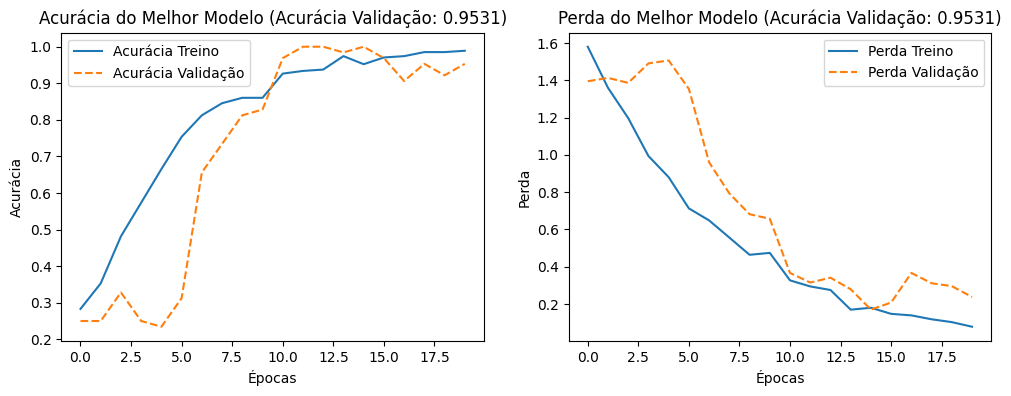

In [21]:
if best_history:
    plt.figure(figsize=(12, 4))
    
    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(best_history['history'].history['accuracy'], label='Acurácia Treino')
    plt.plot(best_history['history'].history['val_accuracy'], label='Acurácia Validação', linestyle='--')
    plt.title(f"Acurácia do Melhor Modelo (Acurácia Validação: {best_accuracy:.4f})")
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    # Gráfico de Perda
    plt.subplot(1, 2, 2)
    plt.plot(best_history['history'].history['loss'], label='Perda Treino')
    plt.plot(best_history['history'].history['val_loss'], label='Perda Validação', linestyle='--')
    plt.title(f"Perda do Melhor Modelo (Acurácia Validação: {best_accuracy:.4f})")
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Exibindo os gráficos
    plt.show()
else:
    print("Nenhum modelo foi encontrado.")

## __Gerando a matriz de confusão para o melhor modelo__

In [22]:
y_true = validation_generator.classes
y_pred = best_model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

2/2 [==============================] - 5s 2s/step


## __Criando a matriz de confusão__

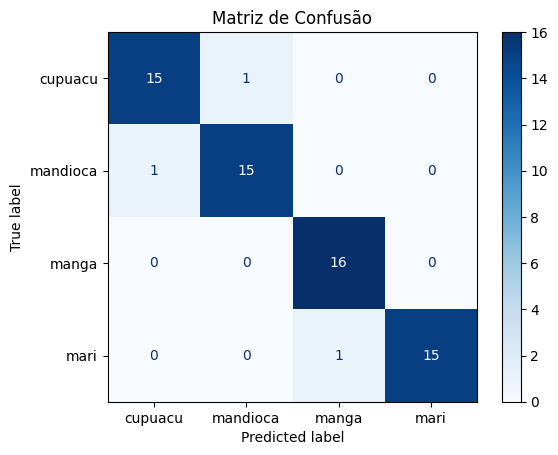

In [23]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

## __Avaliação do modelo com o conjunto de teste__

In [24]:
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Loss no conjunto de teste: {test_loss}")
print(f"Acurácia no conjunto de teste: {test_accuracy}")

4/4 [==============================] - 9s 2s/step - loss: 0.1155 - accuracy: 0.9919
Loss no conjunto de teste: 0.11551059782505035
Acurácia no conjunto de teste: 0.9919354915618896


## ___Gerando Classification Report___

In [ ]:
# Fazendo previsões no conjunto de dados de teste
y_pred = best_model.predict(test_generator, verbose=1)

# Convertendo as probabilidades em classes previstas (se for um modelo de múltiplas classes)
y_pred_classes = np.argmax(y_pred, axis=1)

# As classes reais (rótulos) que o modelo deveria prever
y_true = test_generator.classes

# Gerando o Classification Report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

## __Função de Predição__

In [25]:
def predict_image_class(image_path, model, class_indices):
    # Carregar a imagem
    img = load_img(image_path, target_size=(224, 224))  # Redimensiona para o tamanho usado no modelo
    img_array = img_to_array(img)  # Converte para array numpy
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona uma dimensão para lote
    img_array = img_array / 255.0  # Normaliza os valores para o intervalo [0, 1]

    # Previsão
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions, axis=-1)[0]  # Índice da classe com maior probabilidade

    # Mapeando índice para a classe
    class_labels = {v: k for k, v in class_indices.items()}  # Inverte o mapeamento
    predicted_class = class_labels[predicted_class_idx]

    return predicted_class

## __Exemplo de Previsão__

In [40]:
image_path = pathO + "\\to_predict\\cupuacu.4.jpg"
predicted_class = predict_image_class(image_path, best_model, train_generator.class_indices)
print(f"A imagem pertence à classe: {predicted_class}")

1/1 [==============================] - 0s 47ms/step
A imagem pertence à classe: mandioca


## __Finalizando o TensorBoard__

In [41]:
%load_ext tensorboard
%tensorboard --logdir .\logs

Reusing TensorBoard on port 6006 (pid 18084), started 4 days, 0:44:48 ago. (Use '!kill 18084' to kill it.)

In [42]:
!taskkill /IM tensorboard.exe /F

ERRO: o processo "tensorboard.exe" nÆo foi encontrado.


In [ ]:
%reload_ext tensorboard